In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from datetime import datetime

In [131]:
#download data and change index column to datetime object 

df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv")

df.set_index("Month", inplace=True)

df.index = pd.to_datetime(df.index, format="%Y/%m")
df = df.iloc[-400:, :]

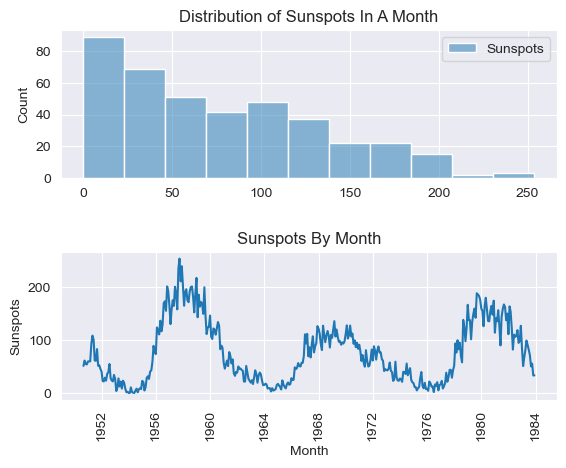

In [132]:
fig, ax = plt.subplots(2, 1)

sns.set_style("darkgrid")
sns.histplot(df, ax=ax[0]).set(title="Distribution of Sunspots In A Month")

sns.lineplot(data=df, x=df.index, y="Sunspots", ax=ax[1]).set(title="Sunspots By Month")

plt.xticks(rotation=90)
fig.subplots_adjust(hspace=.5)
plt.show()

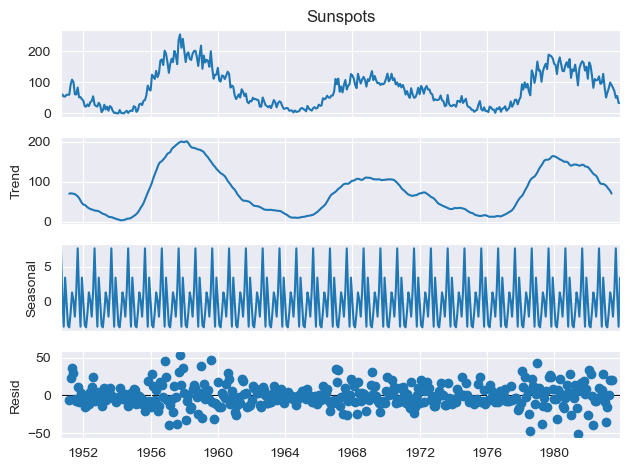

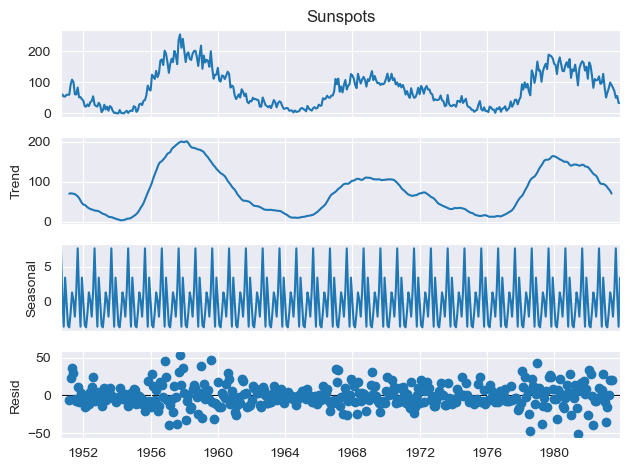

In [133]:
seasonal_decompose(df["Sunspots"], model="additive", period=12).plot()
#strong trend component with what appears to be discernable seasanality, heteroscadasticity observed in the later years 

C:\Users\egrah\AppData\Local\Temp\ipykernel_14448\111354774.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  results_kpss = kpss(df["Sunspots_diff_1"], regression="ct")


ADF: T-statistic: -2.8708111773783007
KPSS: T-statistic: 0.05397368058588611
ADF: P Value: 0.048849070625582684
KPSS: P Value: 0.1
ADF: # of Lags: 17
KPSS: # of Lags: 19
ADF: Observations: 381
KPSS: Observations: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


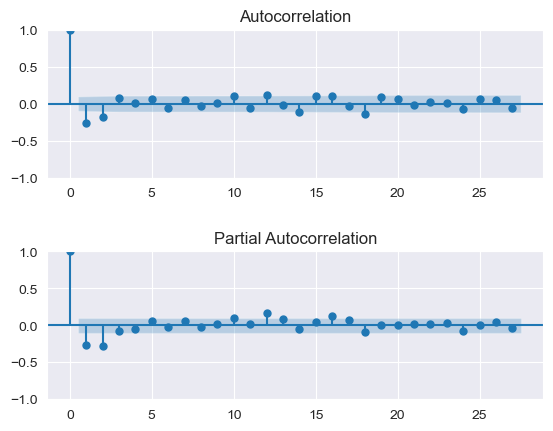

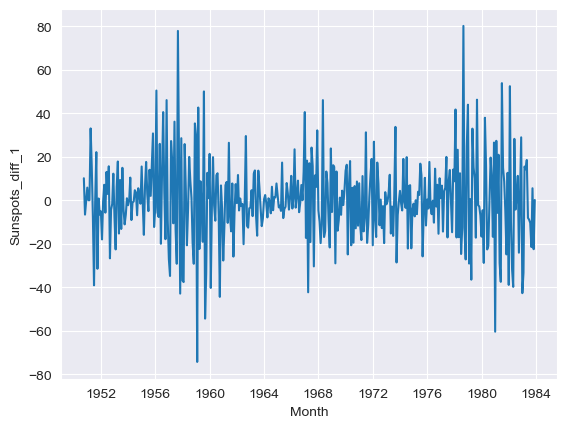

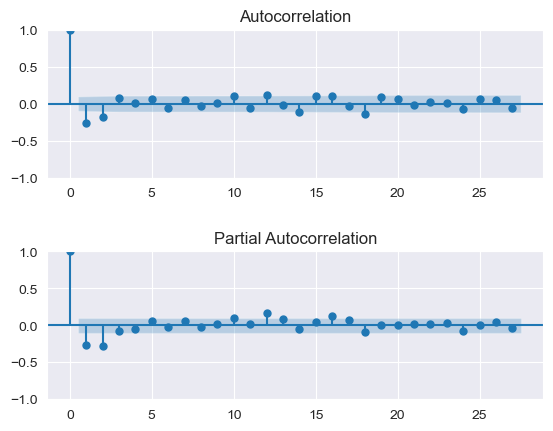

In [134]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#take the first difference of the time series to see if a non-stationary time series can be converted to stationary

df["Sunspots_diff_1"] = df["Sunspots"].diff()
df= df.dropna()

sns.lineplot(data=df, x=df.index, y="Sunspots_diff_1")

results_adf = adfuller(df["Sunspots_diff_1"], autolag="AIC")
results_kpss = kpss(df["Sunspots_diff_1"], regression="ct")

indices = ["T-statistic", "P Value", "# of Lags", "Observations"]

for i in range(len(indices)):
    print(f"ADF: {indices[i]}: {results_adf[i]}")
    print(f"KPSS: {indices[i]}: {results_kpss[i]}")
    
fig, ax = plt.subplots(2,1)

fig.subplots_adjust(hspace=.5)

plot_acf(df["Sunspots_diff_1"], ax=ax[0])
plot_pacf(df["Sunspots_diff_1"], ax=ax[1]) 

#significatn auto-correlation observed for 2-lags

C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\AppData\Local\Temp\ipykernel_14448\2098777650.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecasts["SES"] = ses.fittedvalues.append(preds)


Text(0, 0.5, 'Sunspots')

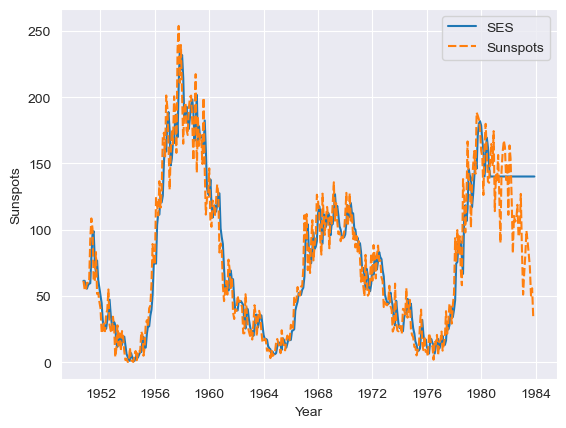

In [135]:
#Time Series Forecasting with Simple Exponential Smoothing 
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, SimpleExpSmoothing, Holt)

test_len = int(np.round(len(df["Sunspots"])*.10, 0))

df_train = df.iloc[:-test_len, 0]
df_test = df.iloc[-test_len:, 0]


ses = SimpleExpSmoothing(df_train).fit()

preds = ses.forecast(len(df_test))

df_forecasts = df.copy()

df_forecasts["SES"] = ses.fittedvalues.append(preds)


sns.lineplot(data=df_forecasts[["SES", "Sunspots"]])
plt.xlabel("Year")
plt.ylabel("Sunspots")



C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\AppData\Local\Temp\ipykernel_14448\146745586.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecasts["double_SES"] = ses.fittedvalues.append(preds)
C:\Users\egrah\AppData\Local\Temp\ipykernel_14448\146745586.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecasts["double_SES_damped"] = ses.fittedvalues.append(preds)


Text(0.5, 0, 'Year')

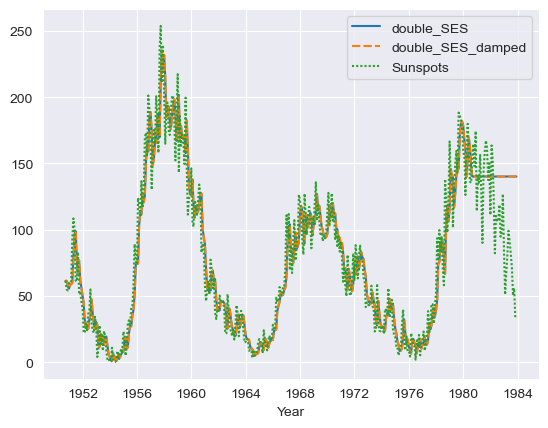

In [136]:
#Double Exponential Smoothing
from sklearn.metrics import mean_squared_error


ses_2_model = Holt(df_train)

ses_2 = ses_2_model.fit()
ses_2_damped = ses_2_model.fit(damping_trend = .7)


preds_2 = ses_2.forecast(len(df_test))
preds_2_damped = ses_2_damped.forecast(len(df_test))

df_forecasts["double_SES"] = ses.fittedvalues.append(preds)
df_forecasts["double_SES_damped"] = ses.fittedvalues.append(preds)


sns.lineplot(data=df_forecasts[["double_SES", "double_SES_damped", "Sunspots"]])
plt.xlabel("Year")

C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\AppData\Local\Temp\ipykernel_14448\1718634801.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecasts["ses_triple"] = ses_3.fittedvalues.append(ses_3_preds)


Text(0.5, 0, 'Year')

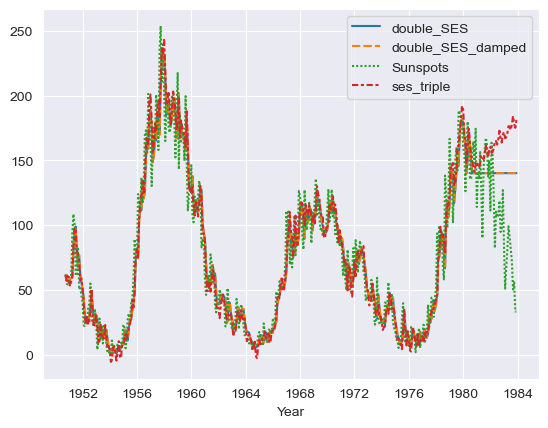

In [137]:
ses_3 = ExponentialSmoothing(df_train, trend="add", seasonal="add", seasonal_periods=12).fit()

ses_3_preds = ses_3.forecast(len(df_test))


df_forecasts["ses_triple"] = ses_3.fittedvalues.append(ses_3_preds)

sns.lineplot(data=df_forecasts[["double_SES", "double_SES_damped", "Sunspots", "ses_triple"]])

plt.xlabel("Year")

#we can see there is much more to the time series than a seasonal component and the trend and level components of the 
#exponential smoothing model are only usually accurate for one period ahead. We will try arma models next

(-2.8708111773783007, 0.048849070625582684, 17, 381, {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}, 3278.5837077088026)


C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Sunspots   No. Observations:                  359
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -1528.018
Date:                Thu, 21 Dec 2023   AIC                           3068.037
Time:                        12:30:08   BIC                           3091.337
Sample:                    10-01-1950   HQIC                          3077.302
                         - 08-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.6524     37.205      1.953      0.051      -0.269     145.573
ar.L1          0.9800      0.011     89.428      0.000       0.958       1.001
ma.L1         -0.3300      0.047     -7.010      0.0

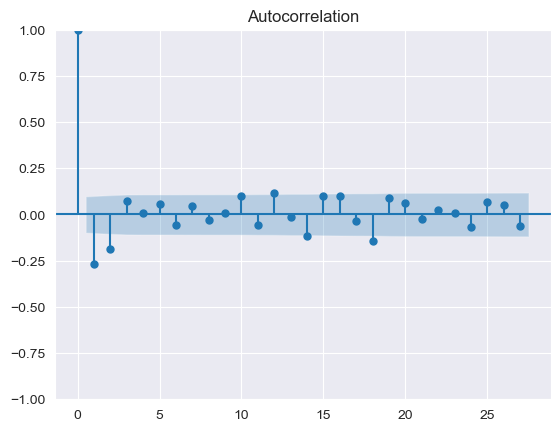

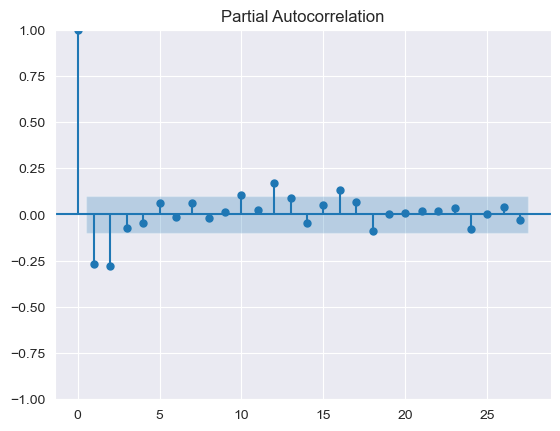

In [138]:
#Arima, Sarima, auto arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

plot_acf(df["Sunspots_diff_1"])
plot_pacf(df["Sunspots_diff_1"])

print(adfuller(df["Sunspots_diff_1"]))

#the augmented dickey fuller test has determined are time series is already stationary with the first difference
#there is strong partial auto correlation in the time seriesup to two lags as observed by the autocorrelation graph 

arima = ARIMA(df_train, order=(1,0,3)).fit()


print(arima.summary())
#after trial an error observing particular p values related to the lagged coefficients the correct order for the model was determined
#Ljung Box test on residuals of the training set appear to show us that they are white noise 
#the probability of our heterscadascticity test on the residuals tells us are models errors do not grow as the time series progresses
#the residuals ARE NOT normally distributed as seen by our jarque-bera test. Our residuals are peaked at the center and our skew is positive so our model overestiamtes the majority of predicitons  
#I minimized the AIC score by adjusting the order hyperparameters

C:\Users\egrah\AppData\Local\Temp\ipykernel_14448\2473281684.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecasts["arima"] = arima.fittedvalues.append(arima.forecast(len(df_test)))


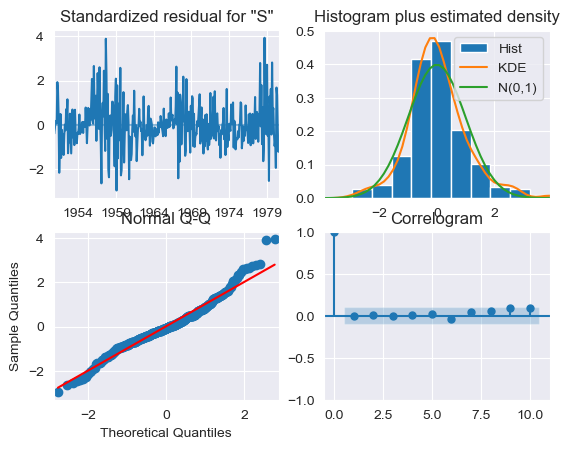

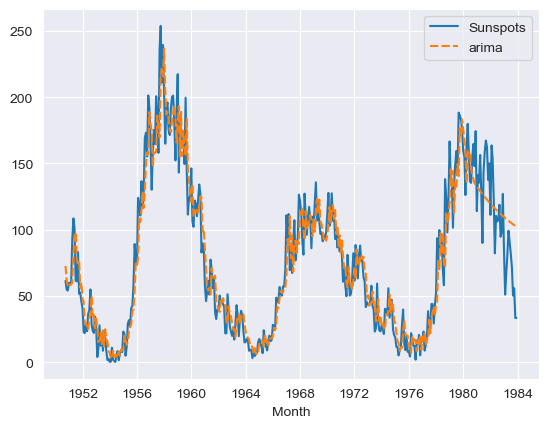

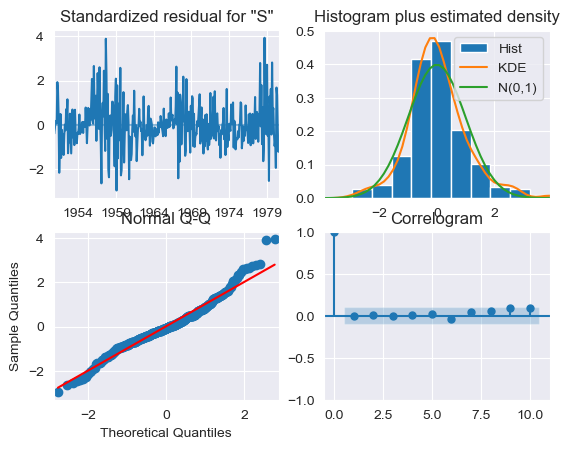

In [139]:
#predict and assess arima model

df_forecasts["arima"] = arima.fittedvalues.append(arima.forecast(len(df_test)))


sns.lineplot(data=df_forecasts[["Sunspots", "arima"]])

arima.plot_diagnostics()


C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\AppData\Local\Temp\ipykernel_14448\2571897706.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecasts["sarima"] = sarima.fittedvalues.append(sarima.forecast(len(df_test)))


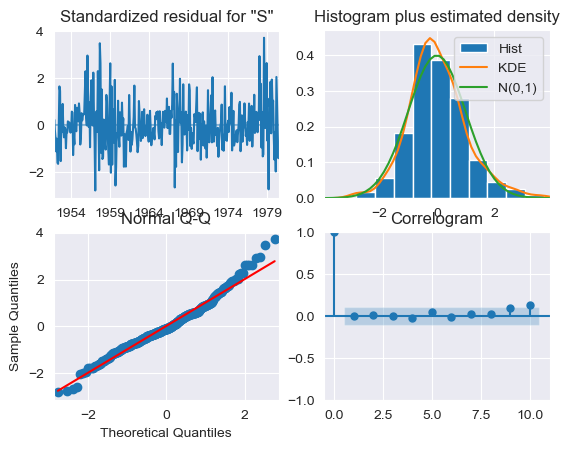

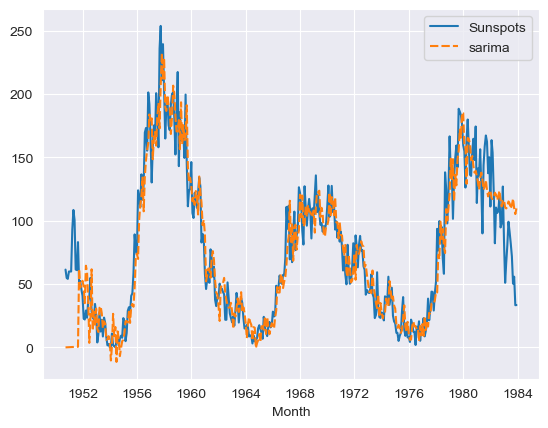

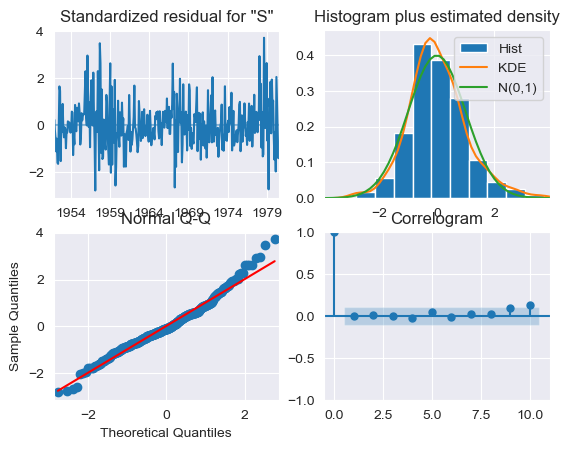

In [140]:
#add a seasonal component 

sarima = ARIMA(df_train, order=(1, 0, 3), seasonal_order=(2,1,1,12)).fit()

df_forecasts["sarima"] = sarima.fittedvalues.append(sarima.forecast(len(df_test)))

sns.lineplot(data=df_forecasts[["Sunspots", "sarima"]])

sarima.plot_diagnostics()



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3066.494, Time=2.23 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3930.181, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3110.152, Time=2.53 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3443.383, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4271.683, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=3064.169, Time=2.39 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=3071.135, Time=0.53 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=3066.174, Time=4.37 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=3064.721, Time=1.71 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=3067.336, Time=4.97 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=3068.965, Time=2.08 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=3071.359, Time=2.04 sec
 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=3066.285, Time=2.76 sec
 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=3065.272, Time=2.10 sec
 ARIMA(1,0,1)(0,0,1

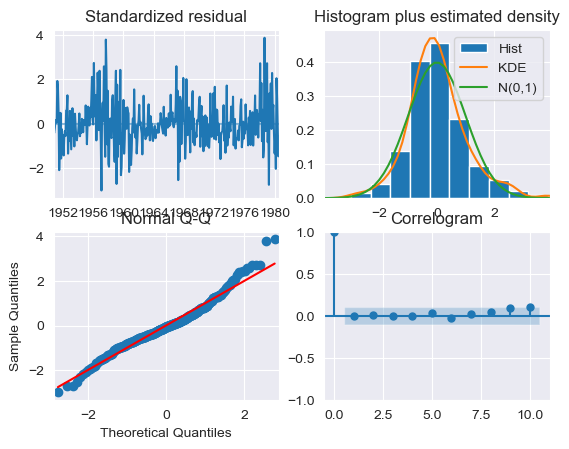

In [141]:
#fit a new model using auto arima
import pmdarima as pm

auto_arima = pm.auto_arima(df_train, trace=True, seasonal=True, m=12)

auto_arima.summary()
auto_arima.plot_diagnostics()

preds = auto_arima.predict(len(df_test))

            Sunspots  Sunspots_diff_1         SES  double_SES  \
Month                                                           
1950-10-01      61.4             10.1   61.400000   61.400000   
1950-11-01      54.8             -6.6   61.400000   61.400000   
1950-12-01      54.1             -0.7   57.508956   57.508956   
1951-01-01      59.9              5.8   55.499199   55.499199   
1951-02-01      59.9              0.0   58.093700   58.093700   
...              ...              ...         ...         ...   
1983-08-01      71.8            -10.4  140.142067  140.142067   
1983-09-01      50.3            -21.5  140.142067  140.142067   
1983-10-01      55.8              5.5  140.142067  140.142067   
1983-11-01      33.3            -22.5  140.142067  140.142067   
1983-12-01      33.4              0.1  140.142067  140.142067   

            double_SES_damped  ses_triple       arima      sarima  auto_sarima  
Month                                                                    

C:\Users\egrah\AppData\Local\Temp\ipykernel_14448\3412893000.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecasts["auto_sarima"] = sarima.fittedvalues.append(preds)


<Axes: xlabel='Month'>

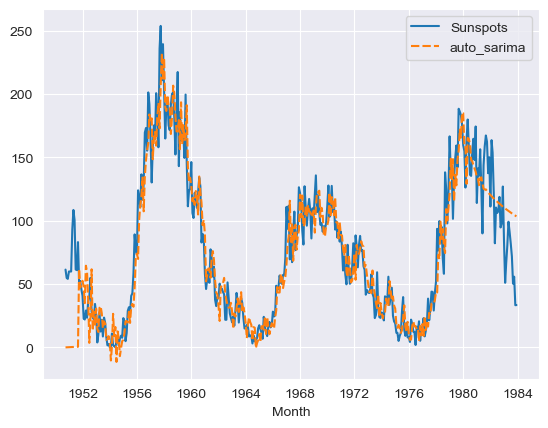

In [142]:

df_forecasts["auto_sarima"] = sarima.fittedvalues.append(preds)

print(df_forecasts)

sns.lineplot(data=df_forecasts[["Sunspots", "auto_sarima"]])

In [143]:
#test each models accuracy 

for index in range(1, len(df_forecasts.columns)):
    print(f"Model - {df_forecasts.columns[index]} - MAPE: {mean_absolute_percentage_error(df_forecasts.iloc[-(len(df_test)):, 0], df_forecasts.iloc[-(len(df_test)):, index])} \n")


Model - Sunspots_diff_1 - MAPE: 1.0672015475954952 

Model - SES - MAPE: 0.5511877150844544 

Model - double_SES - MAPE: 0.5511877150844544 

Model - double_SES_damped - MAPE: 0.5511877150844544 

Model - ses_triple - MAPE: 0.7860296966562278 

Model - arima - MAPE: 0.34332388215669163 

Model - sarima - MAPE: 0.3778187292420311 

Model - auto_sarima - MAPE: 0.3472401349477548 



In [144]:
#perform cross validation techniques for time series data on the best model
from sklearn.model_selection import TimeSeriesSplit

expanding_window_cv = TimeSeriesSplit(n_splits=4, test_size=int(round((len(df)/4)*.2, 0)))

for fold, (train, test) in enumerate(expanding_window_cv.split(df)):
    print(fold)
    print(train)
    print(test)

0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 

C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

walk forward iteration 1, score: 0.630584963521035
walk forward iteration 2, score: 0.6500569156558149
walk forward iteration 3, score: 0.7620103829618451
walk forward iteration 4, score: 0.7270807030669051


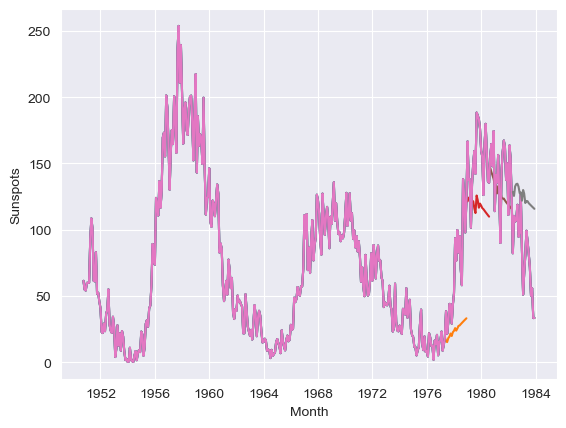

In [145]:
scores = []

for train_indices, test_indices in expanding_window_cv.split(df):
    forecast_model = ARIMA(df.iloc[train_indices, 0], order=(1, 0, 3), seasonal_order=(0,0,1,12)).fit()
    
    preds = forecast_model.forecast(len(test_indices))
    
    sns.lineplot(data=df, x=df.index, y=df["Sunspots"])
    sns.lineplot(data=preds, x=preds.index, y=preds)
    
    scores.append(mean_absolute_percentage_error(df.iloc[-(len(test_indices)):, 0], preds))
    
    
for x in range(len(scores)):
    print(f"walk forward iteration {x + 1}, score: {scores[x]}")

In [146]:
#sliding window cross validation
nsplits=4
testsize = int(round((len(df)/nsplits)*.2, 0))
maxtrainsize = len(df)-(testsize*nsplits)

sliding_window_cv = TimeSeriesSplit(n_splits=nsplits, test_size=testsize, max_train_size=maxtrainsize)

for fold, (train, test) in enumerate(sliding_window_cv.split(df)):
    print(fold)
    print(train)
    print(test)


0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 

C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

walk forward iteration 1, score: 0.630584963521035
walk forward iteration 2, score: 0.6728418407817335
walk forward iteration 3, score: 0.7908398796168885
walk forward iteration 4, score: 0.7616997901137179


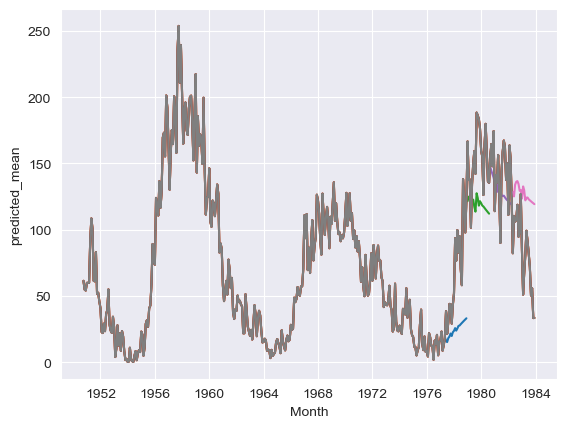

In [147]:
scores = []

for train_indices, test_indices in sliding_window_cv.split(df):
    forecast_model = ARIMA(df.iloc[train_indices, 0], order=(1, 0, 3), seasonal_order=(0,0,1,12)).fit()
    
    preds = forecast_model.forecast(len(test_indices))
    
    scores.append(mean_absolute_percentage_error(df.iloc[-(len(test_indices)):, 0], preds))
    
    sns.lineplot(data=preds, x=preds.index, y=preds)
    sns.lineplot(data=df, x=df.index, y=df["Sunspots"])
    
     
for x in range(len(scores)):
    print(f"walk forward iteration {x + 1}, score: {scores[x]}")
    

In [148]:
#feature extraction for traditional ML modeling on a time series
from sktime.transformations.series.date import DateTimeFeatures
from tsfresh import extract_features
from tsfresh.feature_extraction import settings
from tsfresh.utilities.dataframe_functions import roll_time_series

#simple datetime feature selection using sktime 
transformer = DateTimeFeatures(ts_freq="D", feature_scope="comprehensive")

features = transformer.fit_transform(df)

print(features.head())


            year  quarter_of_year  month_of_year  week_of_year  day_of_year  \
Month                                                                         
1950-10-01  1950                4             10            39          274   
1950-11-01  1950                4             11            44          305   
1950-12-01  1950                4             12            48          335   
1951-01-01  1951                1              1             1            1   
1951-02-01  1951                1              2             5           32   

            month_of_quarter  week_of_quarter  day_of_quarter  week_of_month  \
Month                                                                          
1950-10-01                 1                1               1              1   
1950-11-01                 2                6              32              1   
1950-12-01                 3               10              62              1   
1951-01-01                 1                2 

In [149]:
#in-depth feature selection using tsfresh
ts_df = df.copy().drop(columns="Sunspots_diff_1").reset_index(drop=False)

ts_df.columns = ["Date", "y"]

ts_df["series_id"] = "a"

df_rolled = roll_time_series(ts_df, column_id="series_id", column_sort="Date", max_timeshift=20, min_timeshift=6)

df_rolled_extracted = extract_features(df_rolled.drop(columns=["series_id"]), column_id="id", column_sort="Date", default_fc_parameters=settings.ComprehensiveFCParameters())

df_rolled_extracted = df_rolled_extracted.set_index(df_rolled_extracted.index.map(lambda x: x[1]), drop=True)


C:\Users\egrah\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


In [150]:
#feature selection on engineered features 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

max_features = int(np.round(np.sqrt(len(df_rolled_extracted.columns)), 0))
fs = SelectKBest(score_func=f_regression, k=max_features)

df_engineered = df.join(df_rolled_extracted, how="right")
df_engineered = df_engineered.drop(columns="Sunspots_diff_1")


df_engineered = df_engineered.dropna(axis = 1)


fs.fit(df_engineered.iloc[:, 1:], df_engineered.iloc[:, 0])

cols_idxs = fs.get_support(indices=True)

df_extracted_engineered = df.join(df_engineered.iloc[:, cols_idxs], how='left').dropna()

print(df_extracted_engineered)

            Sunspots  Sunspots_diff_1  y__has_duplicate  y__sum_values  \
Month                                                                    
1951-04-01      92.9             33.0               1.0          442.9   
1951-05-01     108.5             15.6               1.0          551.4   
1951-06-01     100.6             -7.9               1.0          652.0   
1951-07-01      61.5            -39.1               1.0          713.5   
1951-08-01      61.0             -0.5               1.0          774.5   
...              ...              ...               ...            ...   
1983-08-01      71.8            -10.4               1.0         2172.4   
1983-09-01      50.3            -21.5               1.0         2072.6   
1983-10-01      55.8              5.5               1.0         2017.2   
1983-11-01      33.3            -22.5               1.0         1886.9   
1983-12-01      33.4              0.1               1.0         1766.5   

            y__abs_energy  y__mean_se

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='seasonal'>)

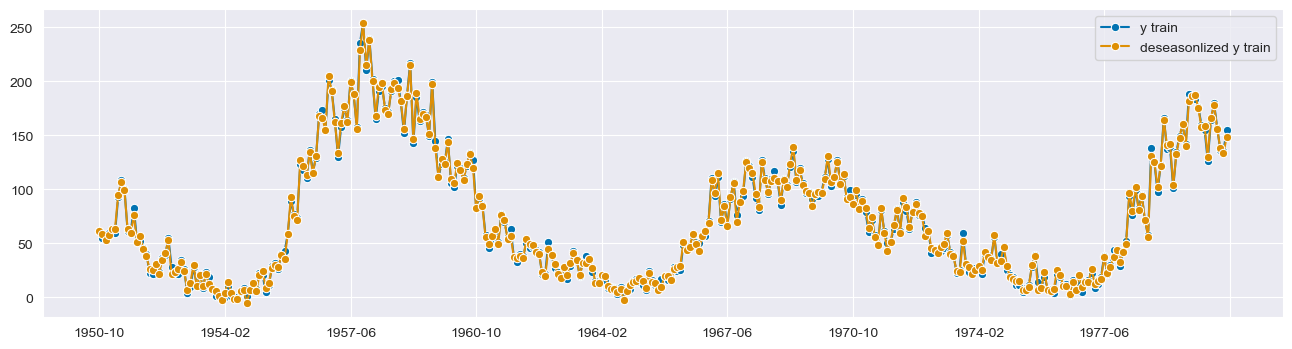

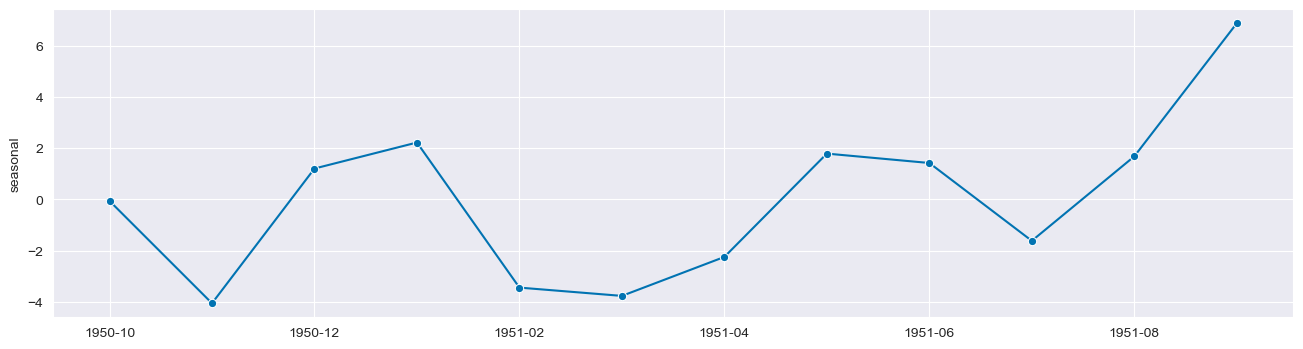

In [151]:
#created a reduced regression model
from sktime.forecasting.model_selection import (temporal_train_test_split, ExpandingWindowSplitter)
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.ensemble import GradientBoostingRegressor as gb
from sktime.transformations.series.detrend import (Deseasonalizer, Detrender)
from sktime.utils.plotting import plot_series
from sktime.forecasting.trend import PolynomialTrendForecaster



reduced_y_train, reduced_y_test = temporal_train_test_split(df.drop(columns = ["Sunspots_diff_1"]), test_size=int(len(df)*.10))

fh = ForecastingHorizon(reduced_y_test.index, is_relative=False)

reduced_y_train.index = pd.PeriodIndex(reduced_y_train.index, freq="M")

#deseasonalize
ds = Deseasonalizer(model="additive", sp=12)
y_deseas = ds.fit_transform(reduced_y_train)

plot_series(reduced_y_train, y_deseas, labels=["y train", "deseasonlized y train"])
#sktime's deseasonlizer seemed to marginally affect the given time series 

plot_series(ds.seasonal_)

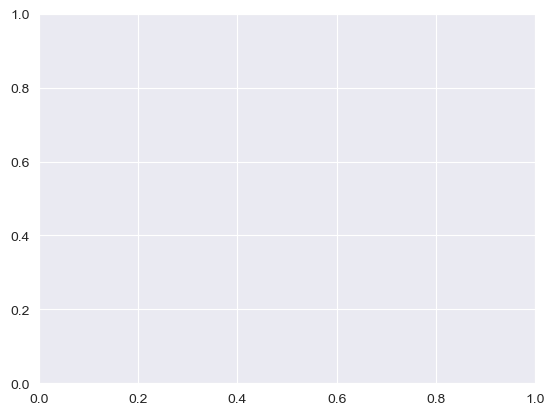

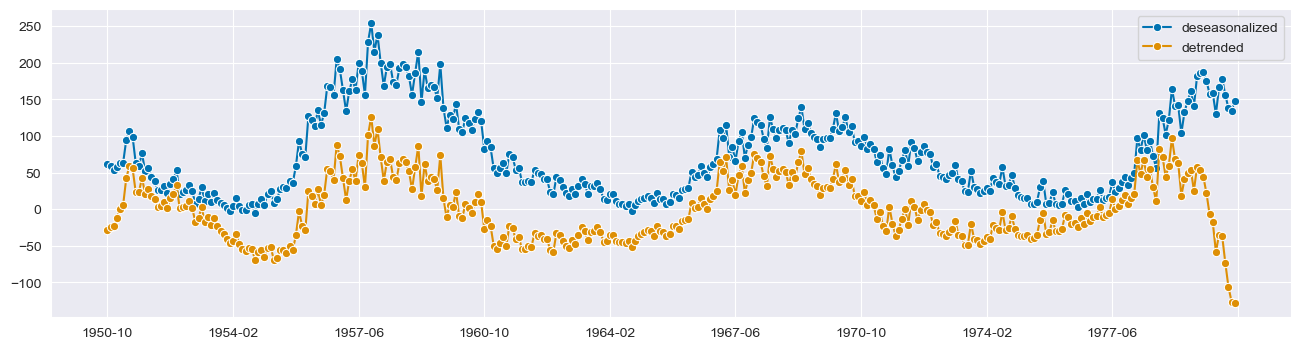

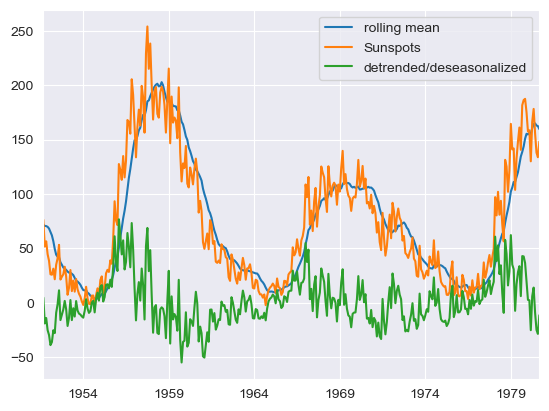

In [152]:
#detrend using sktime's detrender 

trend_model = PolynomialTrendForecaster(degree=6)

dt = Detrender(forecaster=trend_model)

y_detrend = dt.fit_transform(y_deseas)

fig, ax = plt.subplots()

plot_series(y_deseas, y_detrend, labels=["deseasonalized", "detrended"])

#I will see if I can beat sktime's detrending class by removing trend using moving average


y_detrended_2 = pd.DataFrame(y_deseas["Sunspots"].rolling(12).mean().dropna())
y_detrended_2.columns = ["rolling mean"]


y_detrended_2_joined = y_detrended_2.join(y_deseas, how="left")

y_detrended_2_joined["detrended/deseasonalized"] = y_detrended_2_joined["Sunspots"]-y_detrended_2_joined["rolling mean"]


y_detrended_2_joined.plot()
#we can see the models rolling mean follows the original time series accurately. The main component of the time series is trend 
#the residuals from the deasesonalized and detrended time series could be a random walk. We will fit new models to see if we can
#predict 

#window length the size of the number of lags needed to capture seasonality
window_len = 12 


In [153]:
#instantiate ML models 

random_forest_model = rf(random_state=42)
gradient_boost_model = gb(random_state=42)

scores=dict()

#use tabular data from sklearn feature engineering to fit models
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features[features.columns], df["Sunspots"], test_size=.1, shuffle=False)


random_forest_model.fit(x_train[x_train.columns], y_train.tolist())
sktime_preds_rf = random_forest_model.predict(x_test[x_test.columns])

scores["sktime_features_random_forest"] = mean_absolute_percentage_error(y_test, sktime_preds_rf)

gradient_boost_model.fit(x_train[x_train.columns], y_train.tolist())
sktime_preds_gb = gradient_boost_model.predict(x_test[x_test.columns])

scores["sktime_features_gradient_boost"] = mean_absolute_percentage_error(y_test, sktime_preds_gb)


In [154]:
#use tabular data from tsfresh feature engineering to fit models 

x_train, x_test, y_train, y_test = train_test_split(df_extracted_engineered.iloc[:, 2:].values, df_extracted_engineered.iloc[:, 0].values, test_size=.1, shuffle=False)

random_forest_model.fit(x_train, y_train)
ts_fresh_rf_preds = random_forest_model.predict(x_test)


scores["ts_fresh__features_random_forest"] = mean_absolute_percentage_error(y_test, ts_fresh_rf_preds)


gradient_boost_model.fit(x_train, y_train)
ts_fresh_preds_gb = gradient_boost_model.predict(x_test)

scores["ts_fresh_features_gradient_boost"] = mean_absolute_percentage_error(y_test, ts_fresh_preds_gb)

{'sktime_features_random_forest': 0.719458629019312, 'sktime_features_gradient_boost': 0.6867286999521163, 'ts_fresh__features_random_forest': 0.2560085679337317, 'ts_fresh_features_gradient_boost': 0.2039733734249974, 'reduced_regression_random_forest': 0.9583923268979836}


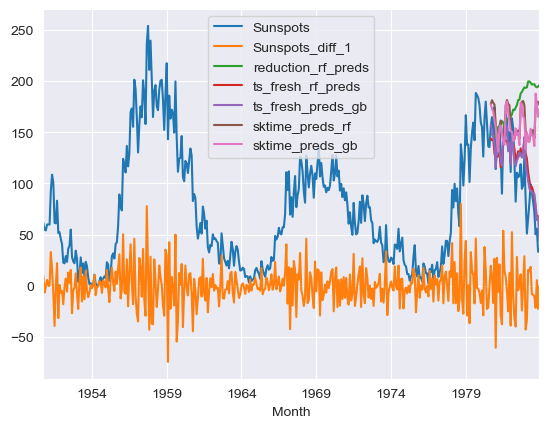

In [155]:
#use tabular data used from reduced regression to fit models


rf_forecaster = make_reduction(estimator=random_forest_model, strategy='recursive', window_length=12)


reduced_y_test.index = pd.PeriodIndex(reduced_y_test.index, freq="M")

fh = ForecastingHorizon(reduced_y_test.index, is_relative=False)


rf_forecaster.fit(y_detrended_2_joined.iloc[:, 2])

reduction_rf_preds = rf_forecaster.predict(fh)


reduction_rf_preds_2 = reduction_rf_preds + y_detrended_2.iloc[-1, 0]

scores["reduced_regression_random_forest"] = mean_absolute_percentage_error(reduced_y_test, reduction_rf_preds_2)


df["reduction_rf_preds"], df["ts_fresh_rf_preds"], df["ts_fresh_preds_gb"], df["sktime_preds_rf"], df["sktime_preds_gb"] = [np.nan, np.nan, np.nan, np.nan, np.nan]
df.iloc[-len(reduction_rf_preds):, df.columns.tolist().index("reduction_rf_preds")] = reduction_rf_preds_2
df.iloc[-len(ts_fresh_rf_preds):, df.columns.tolist().index("ts_fresh_rf_preds")] = ts_fresh_rf_preds
df.iloc[-len(ts_fresh_preds_gb):, df.columns.tolist().index("ts_fresh_preds_gb")] = ts_fresh_preds_gb
df.iloc[-len(sktime_preds_rf):, df.columns.tolist().index("sktime_preds_rf")] = sktime_preds_rf
df.iloc[-len(sktime_preds_gb):, df.columns.tolist().index("sktime_preds_gb")] = sktime_preds_gb

df.plot()

print(scores)

#gradient boosted random forest is the most effective model yet and was able to capture some of the volatility in the test set 

(-2.405062277223528, 0.14031271316997324, 0, 39, {'1%': -3.610399601308181, '5%': -2.939108945868946, '10%': -2.6080629651545038}, 264.8296358499141)


<Axes: ylabel='Count'>

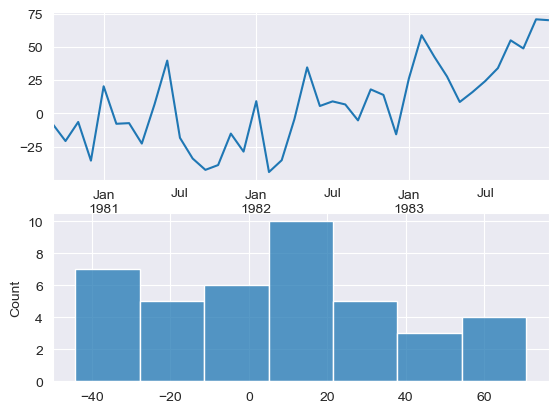

In [156]:
#fit arch/garch models
#we will attempt to explain the volatlity in the time series using a garch model fitted to the residuals of our mean-estimating auto-arima model

from scipy.stats import boxcox
from arch import arch_model

resids = df_forecasts.iloc[-len(df_test):, df_forecasts.columns.tolist().index("auto_sarima")] - df_test

print(adfuller(resids))

fig, ax = plt.subplots(2, 1)
resids.plot(ax=ax[0])
sns.histplot(data=resids, ax=ax[1]) 

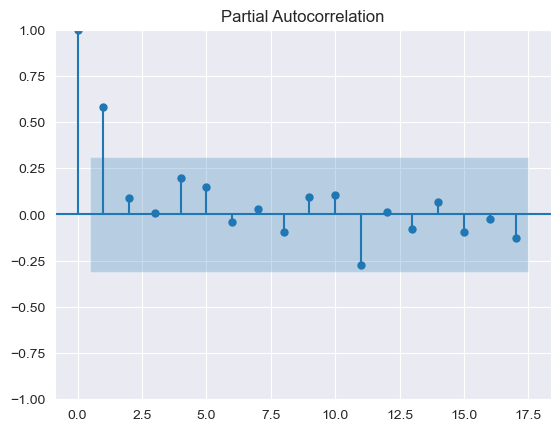

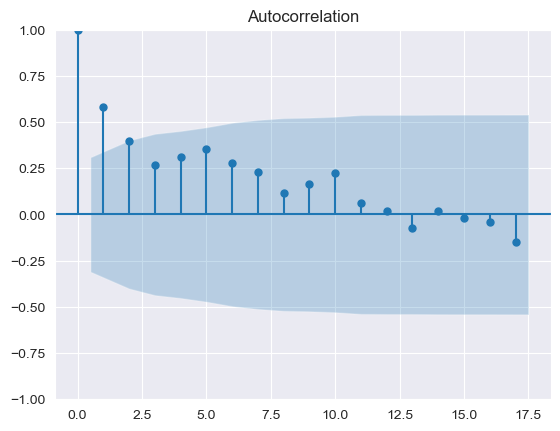

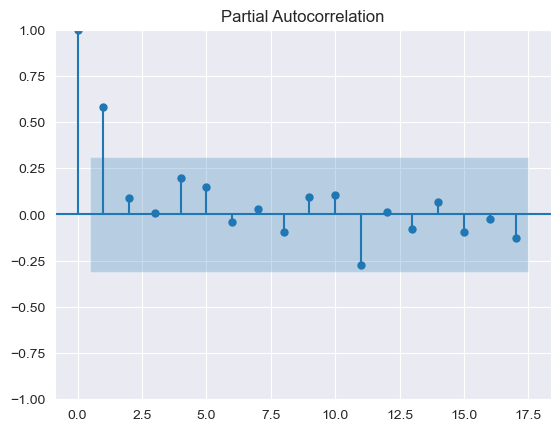

In [157]:
#residuals are not normally distirbuted. We wil use the box-cox transformation method

resids_transformed = resids + (-np.floor(resids.min()))

n_distributed = boxcox(resids_transformed)[0]

#convert back to a zero-mean process
n_distributed = n_distributed - np.mean(n_distributed)

resids_transformed = resids_transformed.to_frame()
resids_transformed.columns = ["resids_transformed"]
resids_transformed["n_distributed"] = n_distributed

plot_acf(resids_transformed["n_distributed"])
plot_pacf(resids_transformed["n_distributed"]) 

#residuals are significantly autocorrelated at lag 1

In [158]:
model = arch_model(resids_transformed["n_distributed"], vol="GARCH", mean="Zero", p=1, q=1, dist="Normal")
fitted_model = model.fit(disp="off")

print(fitted_model.summary())
resids_transformed["conditional_volitility_forecasts"] = fitted_model.conditional_volatility.values

#considerable volitility at lag one observed for both auto-regressive process


                       Zero Mean - GARCH Model Results                        
Dep. Variable:          n_distributed   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.025
Vol Model:                      GARCH   Log-Likelihood:               -140.228
Distribution:                  Normal   AIC:                           286.457
Method:            Maximum Likelihood   BIC:                           291.524
                                        No. Observations:                   40
Date:                Thu, Dec 21 2023   Df Residuals:                       40
Time:                        13:02:50   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         19.5320     18.036      1.083      0.279    [-1